### Imports, plot configuration

In [1]:
# Library imports (see /Utilities/setup_env.py for full import list and figure setup)

from pathlib import Path
import sys

repo_root = Path.cwd().parents[0]  # .../Figure_analysis
repo_root = repo_root.parent       # repo root
sys.path.insert(0, str(repo_root))

from Figure_analysis.Utilities.setup_env import *

### Fetch data from nerd sqlite database

In [2]:
def fetch_fitted_params(db_path, selected_rg_id, selected_site_base, selected_valtype_tc):
    """
    Fetch fitted time-course parameters for a specific rg_id, site_base, and valtype.
    
    Parameters
    ----------
    db_path : str
        Path to the SQLite database file.
    selected_rg_id : int
        Reaction group ID to filter by.
    selected_site_base : str
        Site and base combination (e.g., '18_A', '25_C').
    selected_valtype_tc : str
        Value type for filtering (e.g., 'modrate').

    Returns
    -------
    pd.DataFrame
        DataFrame containing fitted parameters with columns: fit_run_id, log_kobs,
        log_kdeg, log_fmod0, kobs, kdeg, fmod0, log_kobs_err, log_kdeg_err,
        log_fmod0_err, diag_r2.
    """
    conn = sqlite3.connect(db_path)

    # Fetch fitted parameters
    fitted_params_df = pd.read_sql_query(
        """
        WITH run AS (
        SELECT id AS fit_run_id
        FROM probe_tc_fit_runs
        WHERE (rg_id, nt_id) IN (
            SELECT DISTINCT pr.rg_id, mn.id
            FROM probe_reactions pr
            JOIN probe_fmod_values fv ON fv.rxn_id = pr.id
            JOIN meta_nucleotides mn ON mn.id = fv.nt_id
            WHERE pr.rg_id = :rg_id
            AND mn.site || '_' || UPPER(mn.base) = :site_base
        )
        AND fit_kind = 'round3_constrained'
        AND valtype = :valtype_mod
        )
        SELECT
        p.fit_run_id,
        MAX(CASE WHEN p.param_name IN ('log_kobs','logkobs')    THEN p.param_numeric END) AS log_kobs,
        MAX(CASE WHEN p.param_name IN ('log_kdeg','logkdeg')    THEN p.param_numeric END) AS log_kdeg,
        MAX(CASE WHEN p.param_name IN ('log_fmod0','logfmod0')  THEN p.param_numeric END) AS log_fmod0,
        MAX(CASE WHEN p.param_name =  'kobs'                    THEN p.param_numeric END) AS kobs,
        MAX(CASE WHEN p.param_name =  'kdeg'                    THEN p.param_numeric END) AS kdeg,
        MAX(CASE WHEN p.param_name =  'fmod0'                   THEN p.param_numeric END) AS fmod0,
        MAX(CASE WHEN p.param_name IN ('log_kobs_err','logkobs_err')    THEN p.param_numeric END) AS log_kobs_err,
        MAX(CASE WHEN p.param_name IN ('log_kdeg_err','logkdeg_err')    THEN p.param_numeric END) AS log_kdeg_err,
        MAX(CASE WHEN p.param_name IN ('log_fmod0_err','logfmod0_err')  THEN p.param_numeric END) AS log_fmod0_err,
        MAX(CASE WHEN p.param_name =  'diag:r2'                 THEN p.param_numeric END) AS diag_r2
        FROM probe_tc_fit_params p
        JOIN run r ON r.fit_run_id = p.fit_run_id
        GROUP BY p.fit_run_id
        """,
        conn,
        params={"rg_id": selected_rg_id, "site_base": selected_site_base, "valtype_mod": selected_valtype_tc},
    )
    conn.close()
    return fitted_params_df

### Main function definition and execution

In [3]:
# =============================================================================
# Define functions
# =============================================================================

def calc_kadd_from_eyring(temp, m, b, S):
    """
    Calculate the association rate constant (k_add) from Eyring equation parameters.

    Parameters
    ----------
    temp : float
        Temperature in Kelvin.
    m : float
        Slope of the Eyring plot.
    b : float
        Intercept of the Eyring plot.
    S : float
        Concentration of probe in M.

    Returns
    -------
    float
        Association rate constant (k_add) in units of M^-1 s^-1.
    """

    eyring_y = m * (1 / temp) + b
    return (np.exp(eyring_y) * temp) / S

def ode_solution(y0, rates, x):
    """
    Solve a system of ordinary differential equations (ODEs) for chemical probing.

    Parameters
    ----------
    y0 : numpy array
        Initial values for the ODEs - U, R, S, M, Z.
    rates : numpy array
        Rate constants for the ODEs - k_o, k_c, k_add, k_deg.
    x : numpy array
        Time points to evaluate the ODEs.

    Returns
    -------
    x : ndarray
        Array of time points.
    y : ndarray
        Array of the fraction of M over (U + R + M) at each time point.
    """

    @cfunc(lsoda_sig)
    def chem_probing_fastODE(t, y, du, p):
        du[0] = -p[0]*y[0] + p[1]*y[1]
        du[1] = p[0]*y[0] - p[1]*y[1] - p[2]*y[1]*y[2]
        du[2] = -p[2]*y[1]*y[2] - p[3]*y[2]
        du[3] = p[2]*y[1]*y[2]
        du[4] = p[3]*y[2]

    # address to ODE function
    funcptr = chem_probing_fastODE.address
    t_eval = x

    # integrate with lsoda method
    sol, success = lsoda(funcptr, y0, t_eval, data = rates, rtol=1e-8, atol=1e-10)

    # calculate fraction of M over (U + R + M)
    y = sol[:, 3] / (sol[:, 0] + sol[:, 1] + sol[:, 3])

    return y

def pe_model(x, K, k_add, k_deg, S):
    """ Pre-equilibrium assumption model """
    kappa = ((K / (K + 1)) * k_add * S) / k_deg
    return 1 - np.exp(-kappa * (1 - np.exp(-k_deg * x)))

def solve_fmod(k_c, k_add, k_deg, temp = 25, rna_conc = 1e-6, K = 0.5):
    """ Solve the ODEs and calculate the pre-equilibrium assumption and steady-state approximation models """
    
    k_o = K * k_c

    S = 0.01584
    temp += 273.15 # convert to Kelvin

    # Calculate initial conc U, R based on K
    U0 = rna_conc / (1 + K)
    R0 = K * U0
    
    print(f' - U0 = {U0}')
    print(f' - R0 = {R0}')

    # Initial concentrations of U, R, S, M, Z
    y0 = np.array([U0, R0, S, 0.0, 0.0])

    # Rate constants
    rates = np.array([k_o, k_c, k_add, k_deg])
    
    # Print all rate constants
    print(f' - k_o = {k_o}')
    print(f' - k_c = {k_c}')
    print(f' - k_add = {k_add}')
    print(f' - k_deg = {k_deg}')

    # Solve for fmod (% modification)
    x = np.linspace(0, 20000, 25)
    y_ode = ode_solution(y0, rates, x)
    y_pe = pe_model(x, K, k_add, k_deg, S)

    # Calculate residuals
    res_pe = y_pe - y_ode

    return {'x': x, 'y_ode': y_ode, 'y_pe': y_pe, 'res_pe': res_pe}

def plot_solutions(x, y_ode, y_pe, res_pe, t, ax, flag_conc = False):
    """ Plot ODE solution vs pre-equilibrium assumption model """

    if flag_conc == True:
        ax.plot(x, y_ode, label='ODE solution', ls='-', lw = 1)
        ax.plot(x, y_pe, label='Pre-equilibrium assumption', marker = 'o', markersize = 1, ls='', color='#1d2f6f')
        ax.text(0.95, 0.2, rf'{t * 1000:.1f} mM', transform=ax.transAxes, ha='right', va='top', fontsize=10)
    else:
        ax.plot(x, y_ode, label='ODE solution', ls='-', lw = 1, color='#fac748')
        ax.plot(x, y_pe, label='Pre-equilibrium assumption', marker = 'o', markersize = 1, ls='', color='#1d2f6f')
        exp = -int(math.log10(t))
        ax.text(0.95, 0.2, rf'$10^{{{exp}}}$ s', transform=ax.transAxes, ha='right', va='top', fontsize=10)

    return ax

k_add = 0.01794893515911447 M^-1 s^-1
k_deg = 0.00028978168706460445 s^-1
 - U0 = 6.666666666666666e-07
 - R0 = 3.333333333333333e-07
 - k_o = 500000000000.0
 - k_c = 1000000000000.0
 - k_add = 0.01794893515911447
 - k_deg = 0.00028978168706460445
 - U0 = 6.666666666666666e-07
 - R0 = 3.333333333333333e-07
 - k_o = 500000000.0
 - k_c = 1000000000.0
 - k_add = 0.01794893515911447
 - k_deg = 0.00028978168706460445
 - U0 = 6.666666666666666e-07
 - R0 = 3.333333333333333e-07
 - k_o = 500000.0
 - k_c = 1000000.0
 - k_add = 0.01794893515911447
 - k_deg = 0.00028978168706460445
 - U0 = 6.666666666666666e-07
 - R0 = 3.333333333333333e-07
 - k_o = 0.5
 - k_c = 1.0
 - k_add = 0.01794893515911447
 - k_deg = 0.00028978168706460445
 - U0 = 6.666666666666666e-07
 - R0 = 3.333333333333333e-07
 - k_o = 0.0005
 - k_c = 0.001
 - k_add = 0.01794893515911447
 - k_deg = 0.00028978168706460445
 - U0 = 6.666666666666666e-07
 - R0 = 3.333333333333333e-07
 - k_o = 5e-07
 - k_c = 1e-06
 - k_add = 0.017948935159

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


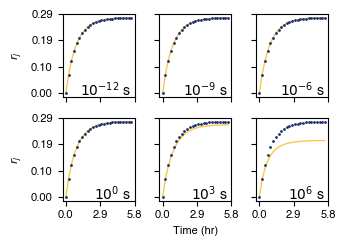

In [4]:
# =============================================================================
# Fetch params for rg_id 10 (WT 4U at 25C representative timecourse at A18 position)
# =============================================================================
# Database path
NERD_SQLITE = '../../Core_nerd_analysis/nerd.sqlite'

kappa = fetch_fitted_params(NERD_SQLITE, 10, "18_A", "modrate")['kobs'].values[0]
kdeg = fetch_fitted_params(NERD_SQLITE, 10, "18_A", "modrate")['kdeg'].values[0]

P_0 = 0.001584 # in M
kadd = kappa * kdeg / P_0

# Print rate constants (s-1)
print(f'k_add = {kadd} M^-1 s^-1')
print(f'k_deg = {kdeg} s^-1')

# =============================================================================
# Solve ODEs and plot
# =============================================================================
timescales = [1e12, 1e9, 1e6, 1e0, 1e-3, 1e-6]
n = len(timescales)
# plot residue in a subplot above
fig, axs = plt.subplots(2, 3, sharey = True, figsize=(3.5, 2.5))

for i, t in enumerate(timescales):
    plot_solutions(**solve_fmod(t, kadd, kdeg, 20), t = t, ax = axs.flat[i])
    axs.flat[i].set_xticks([0, axs.flat[i].get_xlim()[1]/2, axs.flat[i].get_xlim()[1]])

    if i < 3:
        axs.flat[i].set_xticklabels([])

    # Set y-tick marks
    yticks = np.linspace(0, axs.flat[i].get_ylim()[1], 4)
    axs.flat[i].set_yticks(np.linspace(0, axs.flat[i].get_ylim()[1], 4))
    axs.flat[i].set_yticklabels([f"{ytick:.2f}" for ytick in yticks])

# y label for top and bottom row
axs.flat[0].set_ylabel(r'$r_{j}$')
axs.flat[3].set_ylabel(r'$r_{j}$')

# x label for bottom row
axs.flat[4].set_xlabel('Time (hr)')

# scale x axis labels by 3600 (seconds to hrs)
for ax in axs.flat[3:]:
    xticks = ax.get_xticks()
    ax.set_xticklabels([f"{xtick/3600:.1f}" for xtick in xticks])

plt.subplots_adjust(hspace=0.1, wspace=0.2)
plt.tight_layout()
plt.savefig('vary_kclose_timescale.pdf')
plt.show()

 - U0 = 6.666666666666666e-07
 - R0 = 3.333333333333333e-07
 - k_o = 100.0
 - k_c = 200.0
 - k_add = 0.01794893515911447
 - k_deg = 0.00028978168706460445


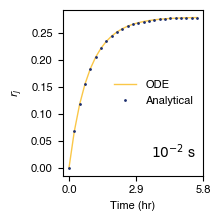

In [5]:

# =============================================================================
# Solve ODEs and plot single 
# =============================================================================

fig, ax = plt.subplots(figsize=(2.25, 2.25))

t = 2e2

plot_solutions(**solve_fmod(t, kadd, kdeg, 25), t = t, ax = ax)
ax.set_xlabel('Time (hr)')
ax.set_ylabel(r'$r_{j}$')
# change legend entries to 'ODE' and 'Analytical'
ax.legend(['ODE', 'Analytical'], frameon=False)

# set only 3 tick marks on x axis
ax.set_xticks([0, ax.get_xlim()[1]/2, ax.get_xlim()[1]])

# # scale x axis labels by 3600 (seconds to hrs)
xticks = ax.get_xticks()
ax.set_xticklabels([f"{xtick/3600:.1f}" for xtick in xticks])

plt.tight_layout()
plt.show()
# plt.savefig('fmod_vs_time_representative.pdf')
# plt.show()

/var/folders/18/qp7ngpw963z9q34k6mzb5jc80000gn/T/ipykernel_90158/1407921285.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{xtick/3600:.1f}" for xtick in xticks])
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


 - U0 = 0.01
 - R0 = 0.005
 - k_o = 5000.0
 - k_c = 10000.0
 - k_add = 0.01794893515911447
 - k_deg = 0.00028978168706460445
 - U0 = 0.006666666666666667
 - R0 = 0.0033333333333333335
 - k_o = 5000.0
 - k_c = 10000.0
 - k_add = 0.01794893515911447
 - k_deg = 0.00028978168706460445
 - U0 = 0.0033333333333333335
 - R0 = 0.0016666666666666668
 - k_o = 5000.0
 - k_c = 10000.0
 - k_add = 0.01794893515911447
 - k_deg = 0.00028978168706460445
 - U0 = 0.0016666666666666668
 - R0 = 0.0008333333333333334
 - k_o = 5000.0
 - k_c = 10000.0
 - k_add = 0.01794893515911447
 - k_deg = 0.00028978168706460445
 - U0 = 6.6666666666666675e-06
 - R0 = 3.3333333333333337e-06
 - k_o = 5000.0
 - k_c = 10000.0
 - k_add = 0.01794893515911447
 - k_deg = 0.00028978168706460445


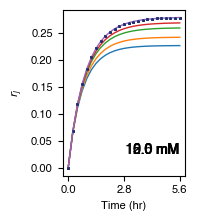

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(2, 2.25))
# 1 uM, 10 uM, 500 uM, 1 mM, 10 mM 
# draw a diagonal line
concs = [0.015, 0.010, 0.005, 0.0025,0.00001]
for i, c in enumerate(concs):
    plot_solutions(**solve_fmod(1e4, kadd, kdeg, 25, c), t = c, ax = ax, flag_conc = True)
    
ax.set_xlabel('Time (hr)')
ax.set_ylabel(r'$r_{j}$')


# scale x axis labels by 3600 (seconds to hrs)
xticks = ax.get_xticks()
ax.set_xticklabels([f"{xtick/3600:.1f}" for xtick in xticks])


plt.tight_layout()
plt.savefig('vary_rna_conc.pdf')
plt.show()